# Info

3 models are tested on bands and vegedation indices data. 
Model training are customised to the dataset structure, please, explore the ``utils.py`` for helper functions before to start.

The function ``get_predictions`` is organised to address common problems of multiclass satellite image classification:

1) leakage of train data to test sample is addressed using GroupShuffleSplit, where groups that must not overlap in train and test data is represented by label data unique plot \
2) class imbalance is addressed by SMOTE option \
3) presence of all target classes is checked at the stage of the train-test split

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#main libraries
import pandas as pd
import geopandas as gpd
import numpy as np


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit


#ML
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, cohen_kappa_score 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#stats
import scipy.stats

In [4]:
#libraries and helpers for visuals

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(['science', 'no-latex']) 
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update({
    "font.family": "Palatino",   
    "font.serif": ["Times"],  
    "font.size":9,
    "axes.labelsize":9,
    "xtick.labelsize" : 9,
    "ytick.labelsize" : 9})   

colors =[
    '#117733', '#9e2a90', '#88ccee', '#ca7878', '#dbd73e', '#c7c7c9', '#60d52a','#418c84' #, '#92462d'
]

dict_normal_names = {1: 'trees', 
2: 'flooded vegetation',
3: 'open water',
4: 'settlements', 
5: 'bare soil',
6: 'agriculture and grass', 
7: 'shrubs',
#8: 'open rocks',
9:'sparse vegetation'
}

In [5]:
#model saving
from joblib import dump, load

In [10]:
#classification customised helpers
from utils import get_predictions, metrics_description, get_classes_metrics, get_metrics_average, get_best_model, get_worst_model

def get_scaled_dataset(path):
    df = pd.read_csv(path)
    x = df.loc[:, df.columns!='id'].values #returns values as a numpy array
    min_max_scaler = preprocessing.MinMaxScaler() #minmax scaling
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled, columns = list(df.loc[:, df.columns!='id'].columns))
    df_scaled = pd.concat([df_scaled, df['id']], axis=1)
    return df_scaled

# Data preparation

In [12]:
df_scaled = get_scaled_dataset('data/general_osm_2021.csv')
df_scaled['id'] = df_scaled['id'].apply(lambda x: 5 if x==8 else x) #works better
df_scaled

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,...,savi,msi,bsi,ndbi,nbi,bal,mbi,ndsoil,blfei,id
0,0.199613,0.167017,0.208243,0.210385,0.316374,0.375967,0.358707,0.356950,0.381057,0.383305,...,0.725588,0.401503,0.693089,0.618811,0.179211,0.550028,0.702748,0.894440,0.162250,9
1,0.223154,0.146403,0.188178,0.182077,0.307519,0.360268,0.337192,0.346057,0.361821,0.355605,...,0.751159,0.429454,0.711765,0.645572,0.163900,0.551282,0.735143,0.920111,0.137507,9
2,0.223154,0.146403,0.188178,0.182077,0.307519,0.360268,0.337192,0.346057,0.361821,0.355605,...,0.751159,0.429454,0.711765,0.645572,0.163900,0.551282,0.735143,0.920111,0.137507,9
3,0.223154,0.255574,0.293745,0.321273,0.376107,0.347455,0.318090,0.315799,0.333791,0.355605,...,0.577217,0.557051,0.823826,0.752672,0.344032,0.663531,0.769656,0.864593,0.224927,9
4,0.223154,0.255574,0.293745,0.321273,0.376107,0.347455,0.318090,0.315799,0.333791,0.355605,...,0.577217,0.557051,0.823826,0.752672,0.344032,0.663531,0.769656,0.864593,0.224927,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933,0.390519,0.267985,0.287780,0.294137,0.336661,0.266074,0.230005,0.214133,0.221673,0.300580,...,0.480378,0.586221,0.810590,0.774182,0.328683,0.630435,0.725392,0.795146,0.308131,5
3934,0.390519,0.332772,0.368402,0.387605,0.408469,0.306476,0.263193,0.250442,0.237611,0.300580,...,0.444722,0.548478,0.806810,0.746160,0.407919,0.668200,0.689668,0.762618,0.345953,5
3935,0.390519,0.332772,0.368402,0.387605,0.408469,0.306476,0.263193,0.250442,0.237611,0.300580,...,0.444722,0.548478,0.806810,0.746160,0.407919,0.668200,0.689668,0.762618,0.345953,5
3936,0.293776,0.304796,0.341829,0.383082,0.413943,0.324945,0.286541,0.293641,0.299166,0.294123,...,0.500465,0.624983,0.866000,0.801304,0.446393,0.711260,0.766810,0.849635,0.267449,5


# Correlation analysis

<AxesSubplot: >

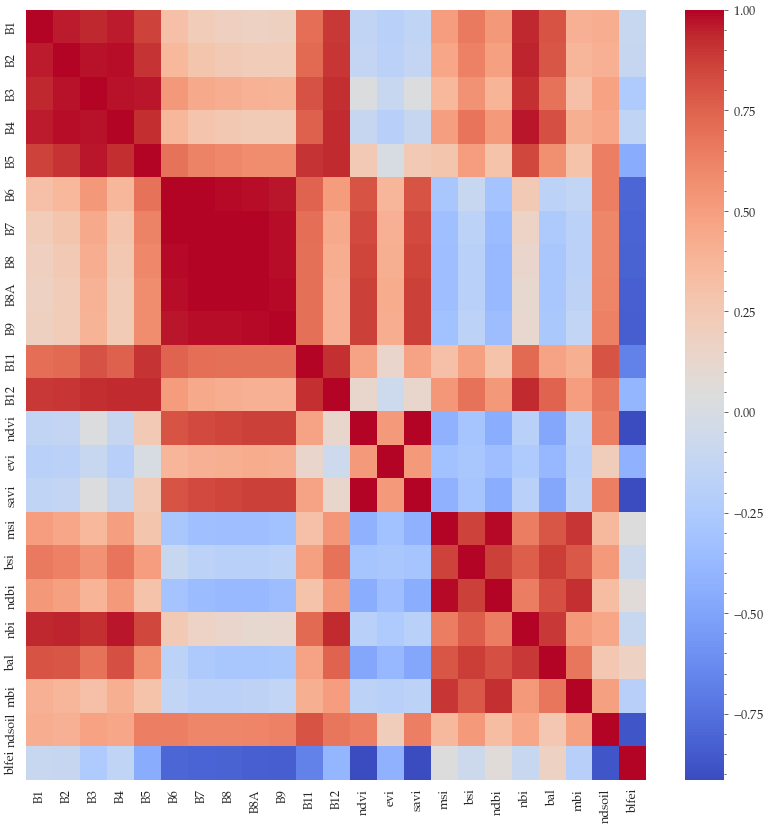

In [14]:
corr = df_scaled.loc[:, ~df_scaled.columns.isin(['id', 'plot'])].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='coolwarm')

In [ ]:
#In case the cleaning based on the correlation analysis is required

# upper = corr.abs().where(np.triu(np.ones(corr.abs().shape), k=1).astype(bool))

# Find features with correlation greater than correlation threshold
# #to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 

# df_scaled = df_scaled.drop(to_drop, axis=1)
# to_drop

# Model training

## Random forest

In [15]:
#for random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# vector of 10 model iterations to evaluate average performance

datavector_rf_wf = []
for i in range(10):
    rf_model = get_predictions(data_scaled = df_scaled,
                model = RandomForestClassifier(),
                param_grid = random_grid,
                target_column = 'id', 
                stratify_column = 'plot',
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_rf_wf.append(rf_model)

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/polinagogol/opt/anaconda3/envs/geo/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `m

Accuracy score: 84.21%
Precision score: 83.27%
Recall score: 84.21%
F1-Score: 69.20%
Kappa score: 79.88%


,names,f1_scores,precision_list,recall
0,trees,0.85,0.84,0.87
1,flooded vegetation,0.58,0.61,0.55
2,open water,1.00,1.00,1.00
3,settlements,0.79,0.81,0.78
4,bare soil,0.86,0.84,0.89
5,agriculture and grass,0.71,0.63,0.81
6,shrubs,0.05,0.07,0.05
7,sparse vegetation,0.68,0.72,0.65


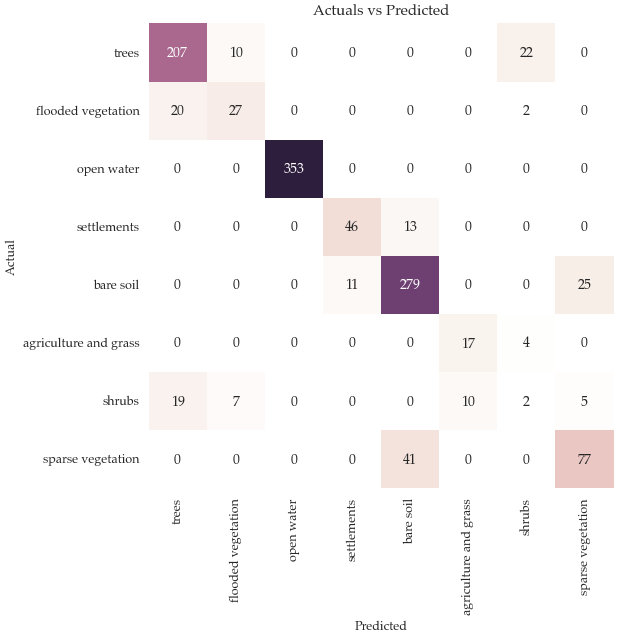

In [16]:
metrics_description(datavector_rf_wf[0]['y test data'], datavector_rf_wf[0]['y predicted'])

In [20]:
rf_class_metrics = get_classes_metrics(datavector_rf_wf)
display(get_metrics_average(datavector_rf_wf))

,iteration,f1_scores,precision_list,recall
0,1,0.69,0.83,0.84
1,2,0.76,0.88,0.89
2,3,0.66,0.83,0.84
3,4,0.71,0.89,0.89
4,5,0.66,0.89,0.84
5,6,0.62,0.75,0.74
6,7,0.64,0.81,0.76
7,8,0.67,0.81,0.81
8,9,0.65,0.87,0.86
9,10,0.69,0.85,0.82


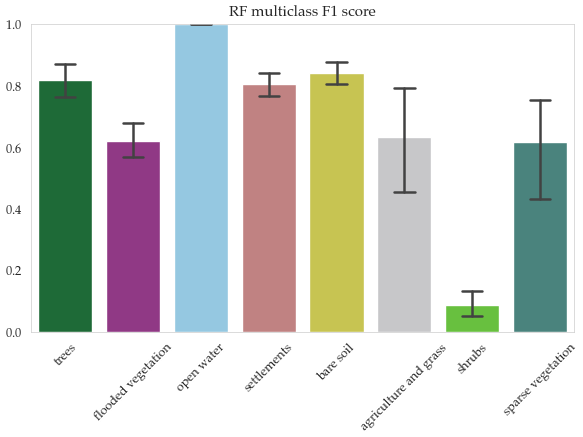

In [19]:
plt.figure(figsize=(7,4))
# plot a bar chart
ax = sns.barplot(x = 'names', y = 'f1_scores', palette=colors, data=rf_class_metrics, estimator=np.mean, ci=95, capsize=.3)
plt.xlabel('')
plt.ylabel('')
plt.title('RF multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('RF_multiclass_F1_score_scale_2.png', dpi = 300)
plt.show()

In [21]:
rf_best_model = get_best_model(datavector_rf_wf)
rf_worst_model = get_worst_model(datavector_rf_wf)

## SVM

In [22]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# vector of 10 model iterations to evaluate average performance

datavector_svc_wf = []
for i in range(10):
    svc_model = get_predictions(data_scaled = df_scaled,
                model = SVC(),
                param_grid = svc_grid,
                target_column = 'id', 
                smote_balance=False,
                stratify_column = 'plot',
                cv=5, 
                n_iter_search=3)
    datavector_svc_wf.append(svc_model)

Accuracy score: 85.48%
Precision score: 86.48%
Recall score: 85.48%
F1-Score: 74.65%
Kappa score: 81.60%


,names,f1_scores,precision_list,recall
0,trees,0.98,0.97,0.99
1,flooded vegetation,0.78,0.74,0.83
2,open water,1.00,1.00,1.00
3,settlements,0.74,0.75,0.73
4,bare soil,0.85,0.81,0.89
5,agriculture and grass,0.53,0.57,0.50
6,shrubs,0.40,0.30,0.58
7,sparse vegetation,0.69,0.91,0.56


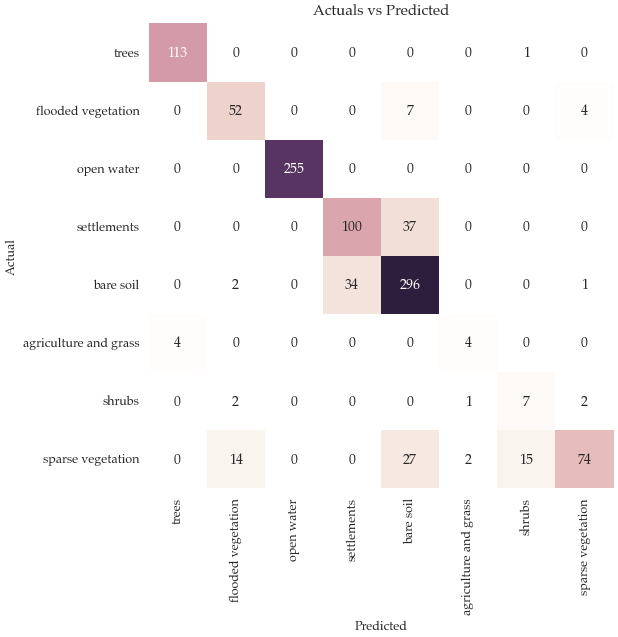

In [23]:
metrics_description(datavector_svc_wf[3]['y test data'], datavector_svc_wf[3]['y predicted'])

In [24]:
svc_class_metrics = get_classes_metrics(datavector_svc_wf)
display(get_metrics_average(datavector_svc_wf))

,iteration,f1_scores,precision_list,recall
0,1,0.72,0.84,0.83
1,2,0.70,0.86,0.82
2,3,0.72,0.89,0.89
3,4,0.75,0.86,0.85
4,5,0.71,0.85,0.84
5,6,0.65,0.82,0.79
6,7,0.75,0.89,0.87
7,8,0.71,0.89,0.85
8,9,0.75,0.89,0.88
9,10,0.78,0.86,0.86


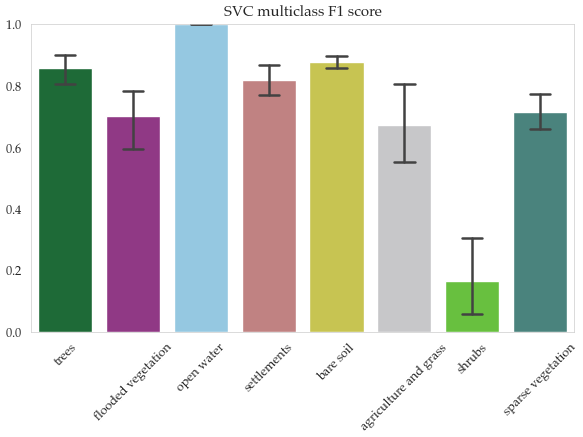

In [25]:
plt.figure(figsize=(7,4))
# plot a bar chart
ax = sns.barplot(x = 'names', y = 'f1_scores', palette=colors, data=svc_class_metrics, estimator=np.mean, ci=95, capsize=.3)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('SVC_multiclass_F1_score_scale_2.png', dpi = 300)
plt.show()

In [29]:
svc_best_model = get_best_model(datavector_svc_wf)
svc_worst_model = get_worst_model(datavector_svc_wf)

## kNN

In [26]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

# vector of 10 model iterations to evaluate average performance on non-filtered data
datavector_knn_wf = []

for i in range(10):
    knn_model_wf = get_predictions(data_scaled=df_scaled,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn,
                target_column = 'id',
                stratify_column = 'plot', 
                smote_balance=False,
                cv=5, 
                n_iter_search=3)
    datavector_knn_wf.append(knn_model_wf)

Accuracy score: 71.32%
Precision score: 70.21%
Recall score: 71.32%
F1-Score: 48.76%
Kappa score: 63.86%


,names,f1_scores,precision_list,recall
0,trees,0.68,0.53,0.93
1,flooded vegetation,0.43,0.67,0.32
2,open water,1.00,1.00,1.00
3,settlements,0.61,0.52,0.73
4,bare soil,0.58,0.60,0.56
5,agriculture and grass,0.00,0.00,0.00
6,shrubs,0.00,0.00,0.00
7,sparse vegetation,0.60,0.64,0.57


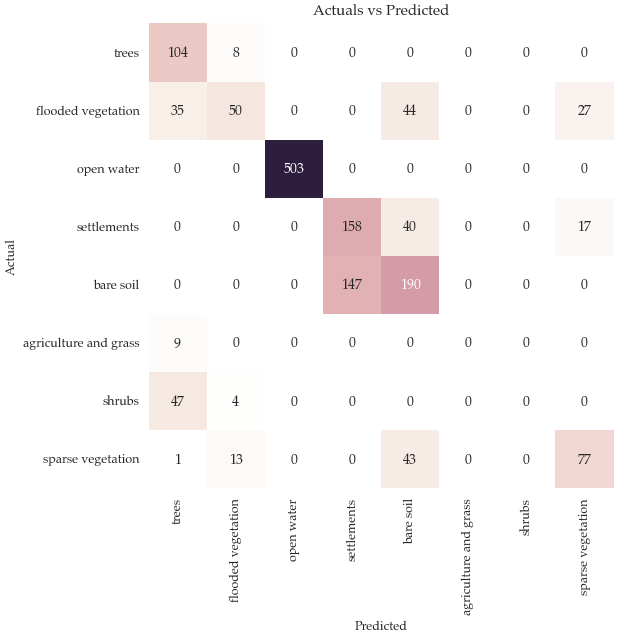

In [27]:
metrics_description(datavector_knn_wf[3]['y test data'], datavector_knn_wf[3]['y predicted'])

In [28]:
knn_class_metrics = get_classes_metrics(datavector_knn_wf)
display(get_metrics_average(datavector_knn_wf))

,iteration,f1_scores,precision_list,recall
0,1,0.66,0.79,0.78
1,2,0.61,0.79,0.72
2,3,0.63,0.82,0.77
3,4,0.49,0.70,0.71
4,5,0.61,0.85,0.81
5,6,0.66,0.81,0.73
6,7,0.55,0.74,0.76
7,8,0.58,0.77,0.76
8,9,0.60,0.81,0.81
9,10,0.61,0.64,0.65


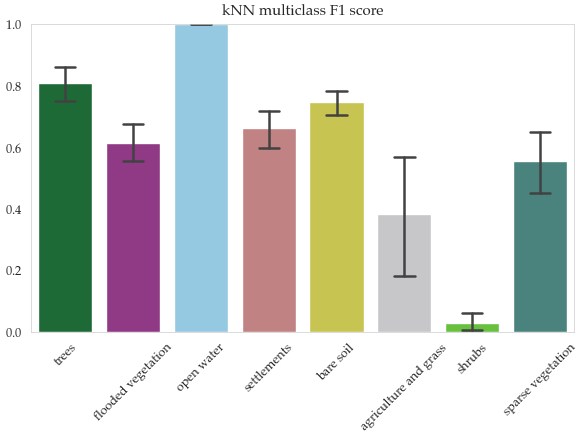

In [30]:
plt.figure(figsize=(7,4))
# plot a bar chart
ax = sns.barplot(x = 'names', y = 'f1_scores', palette=colors, data=knn_class_metrics, estimator=np.mean, ci=95, capsize=.3)
plt.xlabel('')
plt.ylabel('')
plt.title('kNN multiclass F1 score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
#plt.savefig('kNN_multiclass_F1_score_scale_2.png', dpi = 300)
plt.show()

In [31]:
knn_best_model = get_best_model(datavector_knn_wf)
knn_worst_model = get_worst_model(datavector_knn_wf)

# Saving models

In [32]:
dump(svc_best_model, 'svc_best_model.joblib')
dump(rf_best_model, 'rf_best_model.joblib')
dump(knn_best_model, 'knn_best_model.joblib')

dump(svc_worst_model, 'svc_worst_model.joblib')
dump(rf_worst_model, 'rf_worst_model.joblib')
dump(knn_worst_model, 'knn_worst_model.joblib')

['knn_worst_model.joblib']

# Conclusions

According to average scores SVC should show the best performance in its best iteration.
Among classes, the highest certainty in predictions can be expected for trees, barrens, open water.
Next step is to obtained classified maps of the region of interest.